# Heat-Wave Risk assessment

The goal is:

Based on the current climate scenario the occurrence of the heat-wave phenomenon should be more frequent in the future in Europe. The main problems connected with Heat-wave events are the overheating of the urban areas, which lowers the comfort of living or causes health issues[[Integrated Assessment of Urban Overheating Impacts on Human Life](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2022EF002682)], drought, and water scarcity. Nowadays, there are a lot of studies and methodologies on how we can mitigate the influence of these events. This toolbox wants to answer simple questions that are more frequently asked by crisis management local authorities, urban planners, or policymakers. These questions are:

- Where we can expect? (places and magnitude)
- How often? (frequency of the occurrence)
- How to prevent it? (mitigation measures)

# Import packages

In [2]:
import zipfile        # working with the zip folders #
import os             # handling the current working directory
import rasterio       # netcdf and raster processing  #
from pathlib import Path # file system paths
import rioxarray as rxr # netcdf and raster processing
import rioxarray
import cdsapi         # API downloading
import numpy as np    # 2-3D array data handling
import pandas as pd   # data handling #
import xarray as xr   # 2-3D array data handling 
import cartopy.crs as ccrs # netcdf data projection 
import cartopy.feature as cf # netcdf data projection 
import cartopy.crs as ccrs # netcdf data projection 
import matplotlib as mpl  #  data plot #
import matplotlib.pyplot as plt #  data plot #
from rasterio.crs import CRS  #  raster dat handling 
from pylab import pcolormesh,show,colorbar,plot,title,legend,subplot,savefig
from xrspatial.classify import reclassify
from matplotlib import pyplot
from rasterio.plot import show
from glob import glob
import geopandas as gpd
import rasterio as rio
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from ipyleaflet import Map, DrawControl, Marker, LayersControl, LegendControl, GeoData, GeoJSON, WidgetControl
import ipywidgets as widgets
import leafmap.leafmap as leafmap
from localtileserver import get_leaflet_tile_layer, TileClient
from itertools import chain
import copy
from datetime import datetime, timedelta
from localtileserver import get_leaflet_tile_layer, TileClient
import json
import random
import requests
import rasterstats

# Create a directory structure

In [3]:
# Define the directory for the flashflood workflow preprocess
workflow_folder = 'Heat_workflow'

# Define directories for data and results within the previously defined workflow directory
data_dir = os.path.join(workflow_folder,'data')
results_dir = os.path.join(workflow_folder,'results')

# Check if the workflow directory exists, if not, create it along with subdirectories for data and results
if not os.path.exists(workflow_folder):
    os.makedirs(workflow_folder)
    os.makedirs(os.path.join(data_dir))
    os.makedirs(os.path.join(results_dir))

# Set your CDS API key 

- You can download a data from the CDS with the API - look at [[How to change your API KEY](https://cds.climate.copernicus.eu/api-how-to)] and change the KEY

In [ ]:
URL = "https://cds.climate.copernicus.eu/api/v2"
KEY = "!!!!!!!!!!Put your KEY!!!!!!!!!!!!!!!!" ### put here your key

# 1. Trends of the Heat-Days/Nights occurence 

- On the website Climate-adapt we can find the trends of the occurrence of the days with Extreme heat. The content in the European Climate Data Explorer pages is delivered by the Copernicus Climate Change Service (C3S) implemented by ECMWF. 
- We select the region of Slovakia where we can also find Zilina city, this is the estimation for the whole region NUTS2
- Our toolbox in the next steps will provide information from a closer perspective over the Zilina city and Europe.

### Heat days occurence in the past [[Source](https://climate-adapt.eea.europa.eu/en/metadata/indicators/high-utci-days)]

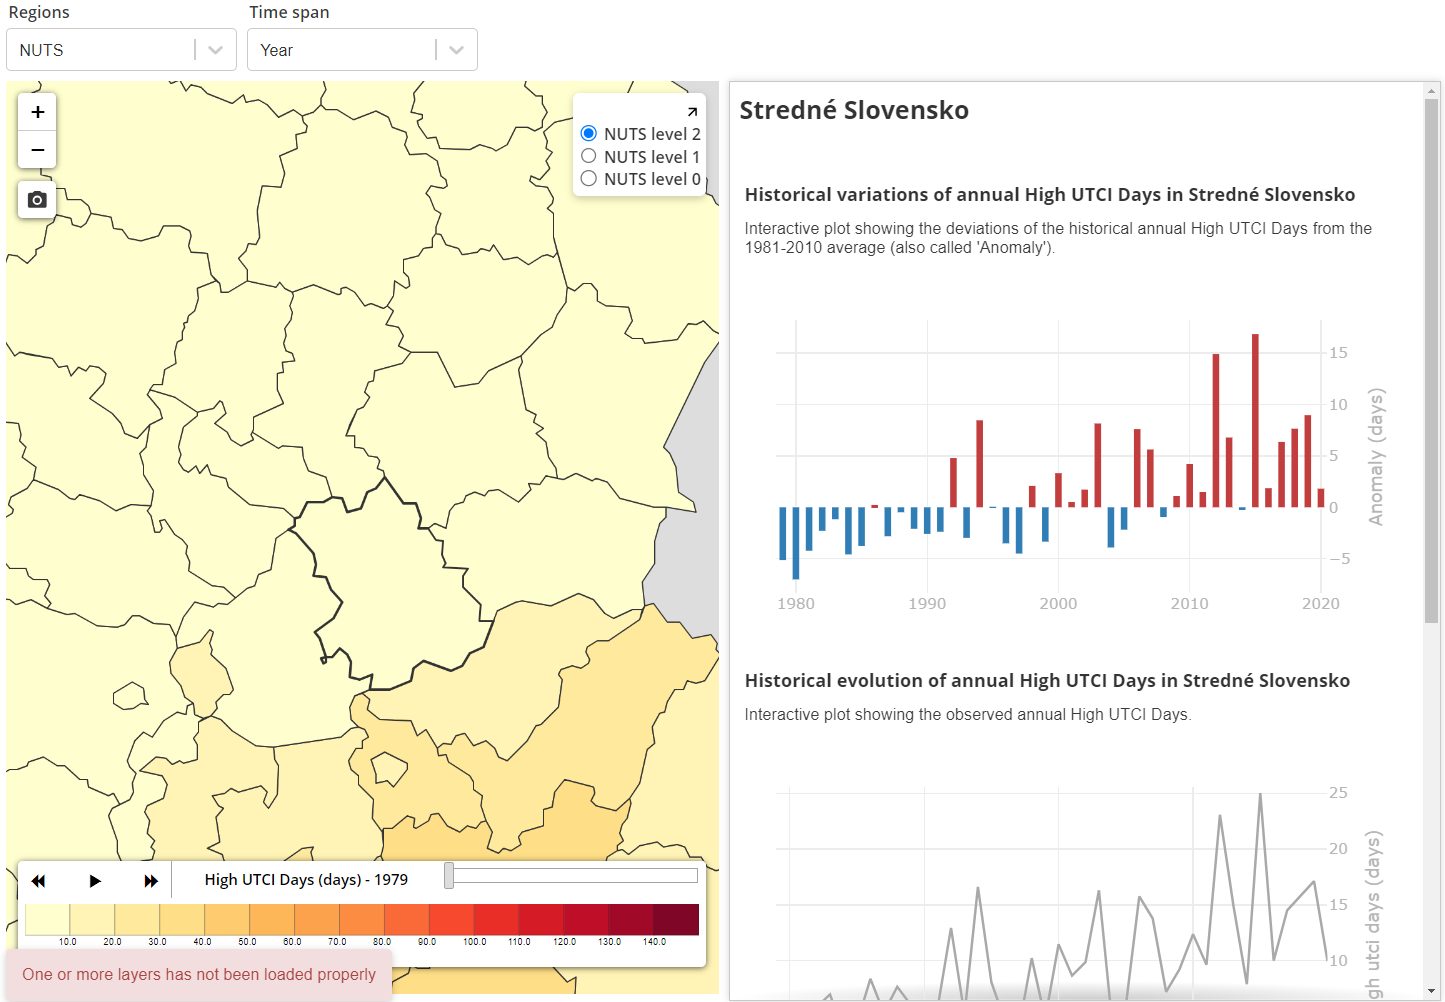

### Heat days occurence in the future [[Source](https://climate-adapt.eea.europa.eu/en/metadata/indicators/apparent-temperature-heatwave-days)]

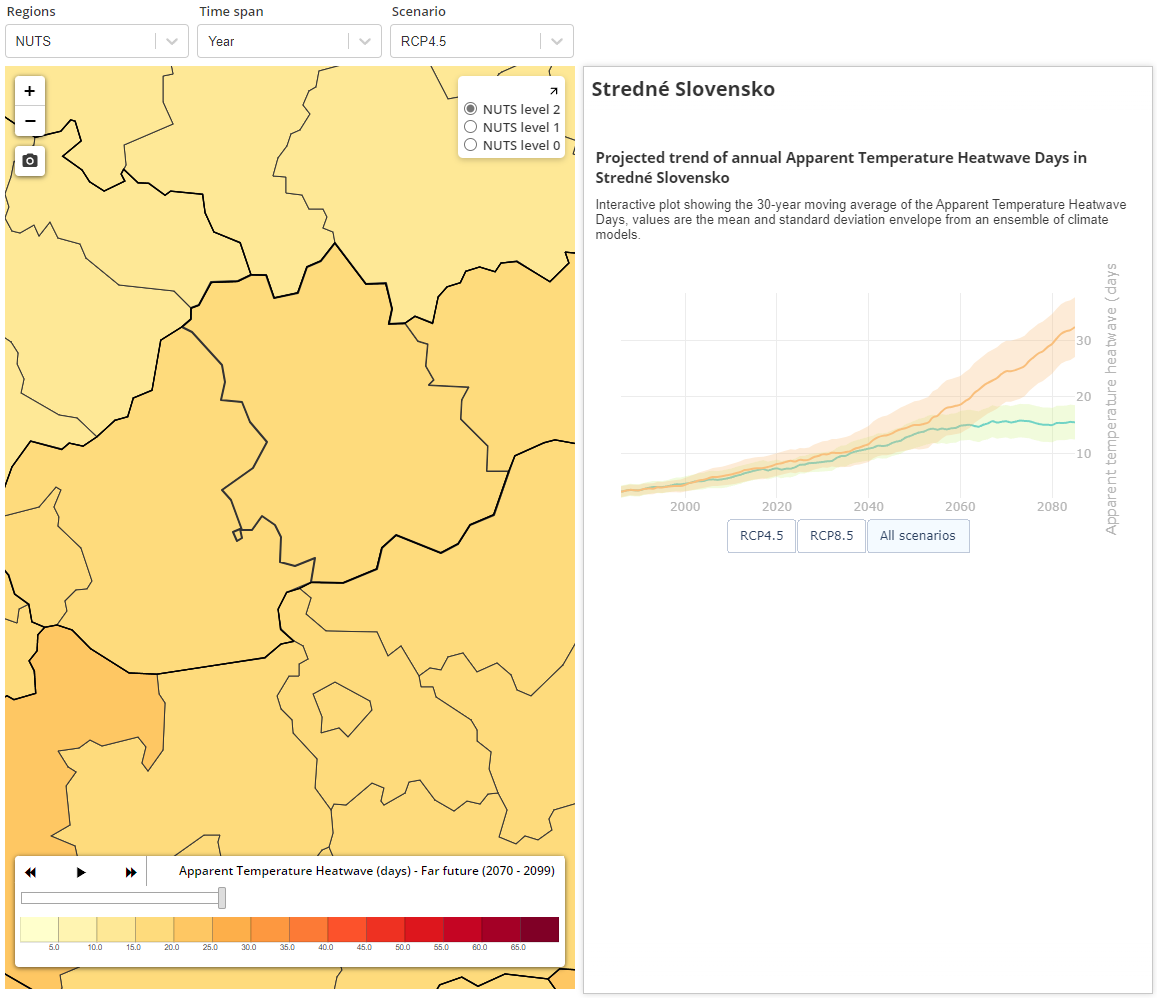

### Tropical night past and projections [[Source](https://climate-adapt.eea.europa.eu/en/observatory/++aq++metadata/indicators/tropical-nights/)]

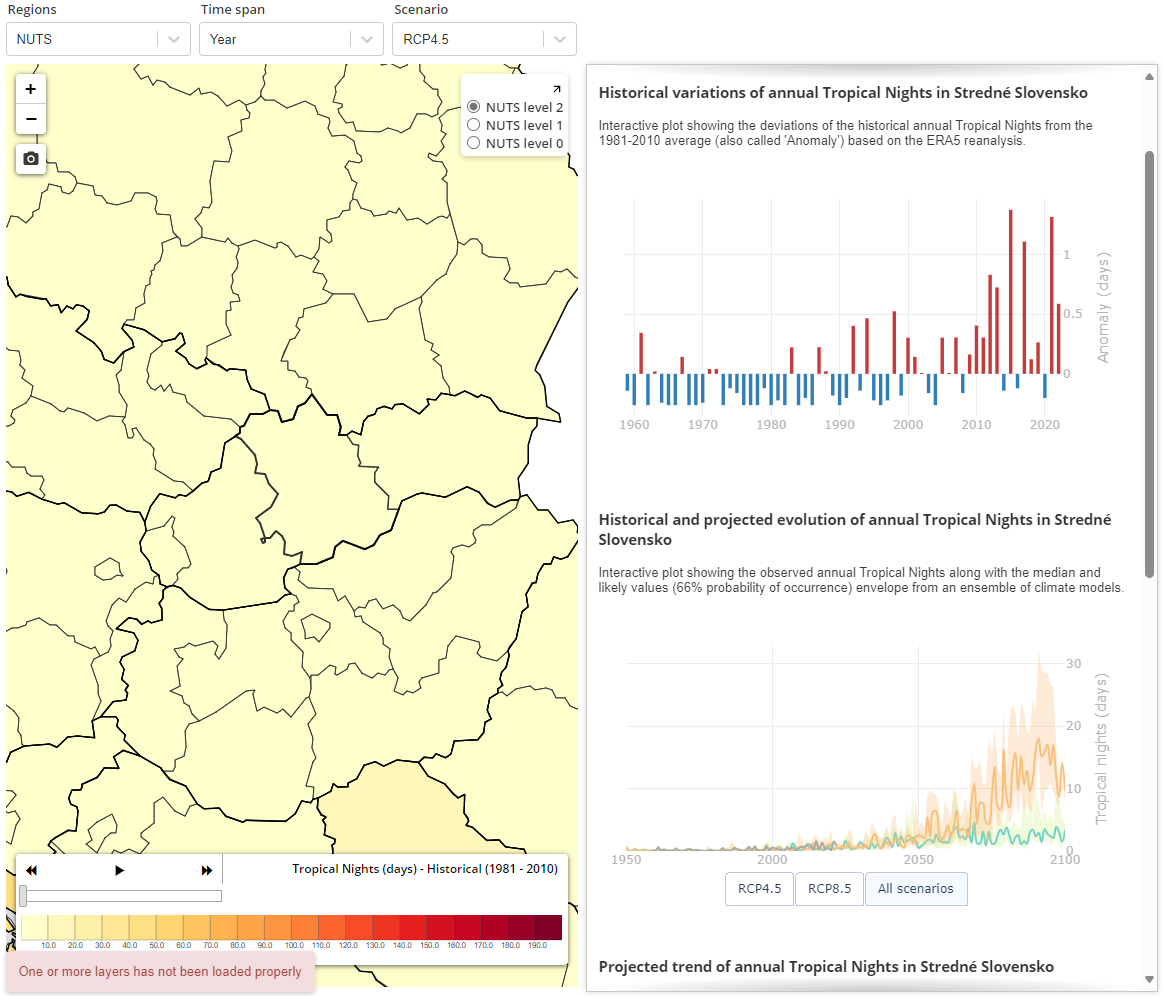

# Observed temperature over Europe 

- In this part of the notebook, we go to the smaller scale than NUTS2. These data give us information about the observed temperature over Europe. These data also help us find the periods with higher air temperatures for the selection of the Landsat8 images. 

### Observed temperature Europe 2011-2023

In [ ]:
# This takes time!!!
c = cdsapi.Client(url=URL, key=KEY)

zip_path = os.path.join(data_dir, 'eobs_airtemp_2011_2023.zip')

c.retrieve(
    'insitu-gridded-observations-europe',
    {
        'product_type': 'ensemble_mean',
        'variable': 'maximum_temperature',
        'grid_resolution': '0.1deg',
        'period': '2011_2023',
        'version': '28.0e',
        'format': 'zip',
    },
   f"{data_dir}/eobs_airtemp_EU_2011_2023.zip")

In [ ]:
# Define zip file's absolute path
zip_path = os.path.join(data_dir, 'eobs_airtemp_EU_2011_2023.zip')
# Extract from zip file
with zipfile.ZipFile(zip_path, 'r') as zObject:
    zObject.extractall(path=data_dir)

# 2 Heat islands identification

#### Heat islands

Heat islands are urbanized areas that experience higher temperatures than outlying areas. Structures such as buildings, roads, and other infrastructure absorb and re-emit the sun’s heat more than natural landscapes such as forests and water bodies. Urban areas, where these structures are highly concentrated and greenery is limited, become “islands” of higher temperatures relative to outlying areas [[Heat islands](https://www.epa.gov/heatislands)]
For the identification of the heat islands from the historical data we can use these data:

Data, needs to be manually downloaded from provided websites, it requires registration and manual choosing of your area and time period (except Euro-Cordex):

#### Historical data from satelite sensors:

- Landsat8 land surface temperature (LST) for the 2016-2020 (15-30m spatial; 8-16 days tremporal). For the identification of the heat island we can use this product, which provide the data about calculated land surface temperature from the Landsat8 imagery. The LST product is available on the RSLAB website, or can be calculated from the L8 imagery bands.
Download:  ### [[RSLAB LST data download](https://rslab.gr/Landsat_LST.html)] (only for 2015-2021) ## recalculation of the LST from Landsat8 imagery [[Landsat8-9 raw images imagery](https://earth.esa.int/eogateway/catalog/landsat-8-collection-2-european-coverage)]


- Sentinel3 LST # [[manual](https://www.youtube.com/watch?v=GbQOZJC6Jgc)] # [[Data Download](https://dataspace.copernicus.eu/browser/?zoom=12&lat=49.178&lng=18.89992&themeId=DEFAULT-THEME&visualizationUrl=https%3A%2F%2Fsh.dataspace.copernicus.eu%2Fogc%2Fwms%2Fa91f72b5-f393-4320-bc0f-990129bd9e63&datasetId=S2_L2A_CDAS )]

### Landsat 8, July 2016 land surface temperature 8 days composite

We can use LST for the summer months (June, July, August) wherewe can expect the overheating of the urban areas. Based on the LST we can easily identified the heat islands (Dark Red areas).

- for the best estimation of the overheated areas it is best to consult the selection of the days with local Meteorological authorities, they can provide the data about measured air temperature from past. 
- or you can look at the at the observed ait temperature in [[CDS Observed temperature 12x12km](https://cds.climate.copernicus.eu/cdsapp#!/dataset/insitu-gridded-observations-europe?tab=form)]

for [[Download of the precomputed LST](https://rslab.gr/Landsat_LST.html)] (for years 2013-2021) for [[Calculation of the LST](https://www.youtube.com/watch?v=hd7fscNTff4)] for [[Download of the precomputed LST](https://rslab.gr/Landsat_LST.html)] (for years 2013- till now)

### Landsat8 Land surface temperature

**Before downloading the data create a new folder in the data_dir called LST, where you download data. Then you can proceed with this code.** 

- Download all available **[all available years for summer months June, July, August, in the south of the EU you also download a data form May and September]** LST imagery and save it to the created LST folder. You do not need to unzip a data, because you can do it automatically with the following code (below)
1. You can download the precomputed values from the RSlab web portal for years 2013-2021 # [[LST data download](https://rslab.gr/Landsat_LST.html)]
    - How to use the RSLAB:
    - (1.) Draw a polygon on the map by clicking (not dragging) on the map to select the vertices of the polygon.
    - (2.) Select your preferred Landsat source. Please check the availability for each Landsat above. It is recommended to use MODIS and NDVI-based emissivity for Urban/Peri-Urban areas and ASTER emissivity for Natural/Isolated areas. Refer to the paper for more details-
    - (3.) Select your preferred emissivity source. Please check the important notes above about emissivity. For more details on this subject please refer to the paper 
    - (4.) Click the "Calculate LST" button.
    - (5.) The results will be presented below the map. For each LST result you will find a "show" button that displays the LST as a layer on the map and calculates the mean/min/max LST value for the selected image.
    - (6.) For each LST result you will find a "download" button that downloads the LST as a .tiff image .to download all the images click the "download all" button at the end of the list. The downloaded .tiff is cut based on your polygon.
      
2. Or you can calculate the LST directly from the Landsat imagery # 
 [[Manual for computation](https://www.youtube.com/watch?v=hd7fscNTff4)].

-  Save data to your Heat_workflow folder /data_dir/LST.
-  Then you can continue with the following code.

In [ ]:
# This code unzips all downloaded LST data 
working_directory = os.path.join(data_dir, 'LST')
# Loop through all files in the directory
for file in os.listdir(working_directory):
    file_path = os.path.join(working_directory, file)
    # Check if the file is a zipfile
    if zipfile.is_zipfile(file_path):
        # Open the zipfile
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            # Extract all contents of the zipfile into the working directory
            zip_ref.extractall(working_directory)

In [5]:
# This code creates a list od date times based on the downloaded LST data
L8list = glob(f"{data_dir}/LST/20*.tif")
file_list = L8list
# Initialize an empty list to store the datetime objects
date_list2 = []
# Loop through each filename
for file in file_list:
    # Extract the date part from the filename
    date_str = file.split('\\')[-1].split('_')[0]
    # Convert the date string to a datetime object
    date = datetime.strptime(date_str, '%Y%m%d')
    # Append the datetime object to the date_list
    date_list2.append(date)

In [4]:
# This code will create a raster stack from all downloaded data
# Load a data and crate a raster stack from all maps
L8list = glob(f"{data_dir}/*LST.tif")
#
with rasterio.open(L8list[0]) as src0:
    meta = src0.meta
#
meta.update(count = len(L8list))
# Save a data to working directory
with rasterio.open(f'{data_dir}/Landsat8_raster_stack.tif', 'w', **meta) as dst:
    for id, layer in enumerate(L8list, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1))

- In this step, you reclassify the LST into 6 categories based on the temperature
- You can change the treshold values for each category:
  1. **No overheat** - no data because of the water
  2. **Very low** < 20°C
  3. **Low** > 20°C
  4. **Medium** > 30°C
  5. **High** > 40°C
  6. **Very High** > 50°C
- We need to realize that these values represent the Surface temperature, not the air temperature. The surface temperature reaches higher values than air temperature. Ground surface temperature has become an important component of weather. The temperature of the ground surface can be more than 10 C above air temperature on a sunny day and up to 10 C below air temperature on clear nights, when the surface loses heat by radiation to the cold infinity of outer space. Like most environmental sensors, infrared sensors have become more accurate and lower cost over the past 10 years. [[Land surface temperature vs air temperature](https://caas.usu.edu/weather/graphical-data/surface-temperature)]


Text(0.5, 1.0, 'Overheated areas in Zilina city')

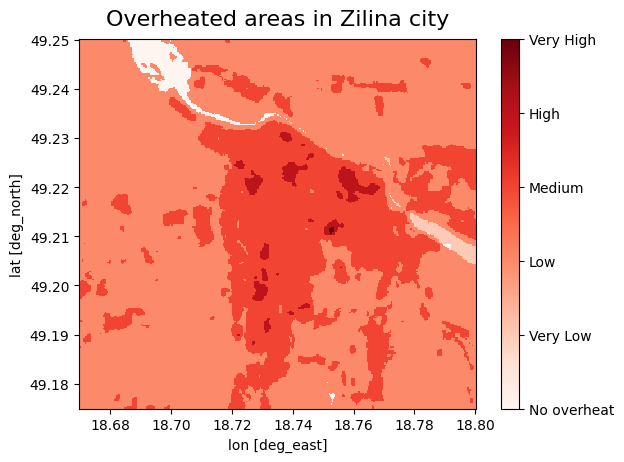

In [37]:
# This code calculates the maximum values from the raster stack of the LST and reclassifies the LST data into 5 groups based on the temperature
# Laod a data calculate maximum values from raster stack
L8 =f'{data_dir}/Landsat8_raster_stack.tif'
L8 = xr.open_dataset(L8)
L8=L8.max(dim='band', skipna=True,  keep_attrs=True)
L8lst2016=L8['band_data']
L8lst2016=L8lst2016.rio.clip_box(minx=18.67, miny=49.175, maxx=18.8, maxy=49.250)
# Reclasiffy data to the groups by the temperature 
lc_bins=[0,20, 30, 40, 50, 100] ### You can change the bins based on yours thresholds
lc_values=[0, 1, 2, 3, 4, 5]
lc_class = reclassify(L8lst2016, bins=lc_bins, new_values=lc_values)
# Plot a data
fig, ax = plt.subplots()
oa = lc_class.plot(ax = ax, cmap='Reds', add_colorbar=False)
cbar = fig.colorbar(oa, ticks=[0, 1, 2, 3, 4, 5])
cbar.ax.set_yticklabels(['No overheat', 'Very Low', 'Low', 'Medium', 'High', 'Very High'], size=10)
ax.set_xlabel('lon [deg_east]')
ax.set_ylabel('lat [deg_north]')
plt.title('Overheated areas in Zilina city', size=16, pad = 10)

In [31]:
# Save data on disk
lc_class.rio.to_raster(raster_path=f'{results_dir}/LSTZA.tif')

### Calculation of the Landsat LST from Landsat 8 - 9 imagery

Calculation of the Landsat LST from Landsat 8 - 9 imagery
data are from european space agency.
For the data download you need to choose the level of the data L1 or L2.
L1 level contains all 11 bands
L2 level contains bands 1-7 and band 10
We need to download the L8-9: [[Manual](https://www.youtube.com/watch?v=Eug32jeK8Gw)], [[Data](https://earth.esa.int/eogateway/catalog/landsat-8-collection-2-european-coverage)], [[Process](https://www.youtube.com/watch?v=hd7fscNTff4)]

### You do not need to calculate you can download it from [[RSLAB](https://rslab.gr/Landsat_LST.html)] for years 2013-2021

- but if you want to most recent data (2022-Now) you need to calculate it:

In [ ]:
# Radiance
rad=0.00033420 * b10 + 0.1

In [ ]:
# Brightest temperature
bt=1321.0789/np.log(774.8853/rad + 1)-272.15

In [ ]:
# Normalized difference vegetation index
ndvi=(b5-b4)/(b5+b4)
ndvi_min=ndvi.min(skipna=True)
ndvi_max=ndvi.max(skipna=True)

In [ ]:
# Proportion of the Vegetation 
pv=((ndvi +  ndvi_min)/(ndvi_max+ndvi_min))**2

In [ ]:
# emisivity
emi=0.004*pv+0.986

In [ ]:
# land surface temperature
LST=(bt+1)+10.8*(bt/14380)*np.log(emi)

# Observed maximum 2m air temperature

In [6]:
# This code plots a map where you need to select a bounding box, as an area for the heat wave estimation
# Create a map centered at a specific location
m = Map(center=(0, 0), zoom=2)
# Create lists to store rectangle coordinates
min_lon_list = []
min_lat_list = []
max_lon_list = []
max_lat_list = []
# Create a DrawControl with rectangle drawing enabled
draw_control = DrawControl(rectangle={'shapeOptions': {'color': '#ff0000'}})
# Add the DrawControl to the map
m.add_control(draw_control)
# Create a text widget to display coordinates
coord_output = widgets.Text(placeholder='Coordinates will appear here', disabled=True)
# Define a function to handle draw events
def handle_draw(self, action, geo_json):
    if action == 'created':
        if geo_json['geometry']['type'] == 'Polygon':
            # Extract coordinates of the rectangle
            coords = geo_json['geometry']['coordinates'][0]
            # Compute rectangle coordinates (min_lon, min_lat, max_lon, max_lat)
            min_lon, min_lat = min(coord[0] for coord in coords), min(coord[1] for coord in coords)
            max_lon, max_lat = max(coord[0] for coord in coords), max(coord[1] for coord in coords)
            # Update text widget with coordinates
            coord_output.value = f'Coordinates: ({min_lon:.2f}, {min_lat:.2f}), ({max_lon:.2f}, {max_lat:.2f})'
            # Append coordinates to lists
            min_lon_list.append(min_lon)
            min_lat_list.append(min_lat)
            max_lon_list.append(max_lon)
            max_lat_list.append(max_lat)
# Attach the event handler to the DrawControl
draw_control.on_draw(handle_draw)
# Arrange the map and text widget vertically
display(widgets.VBox([m, coord_output]))

In [39]:
# This code extracts the coordinates from the bounding box selected above and transform it to Rotated pole coordinates
a=min_lon_list + min_lat_list
b=max_lon_list + max_lat_list
wgs84_coords = [(a), (b)]
#print("WGS 84 Coordinates:", wgs84_coords)
# This code will create a list from the coordinates
list_of_tuples = wgs84_coords
# Convert the list of tuples to a single tuple
bbox = tuple(chain.from_iterable(list_of_tuples))
#print(bbox)

In [41]:
# This code crops the Observed temperature data to your selected BBox (from map above), and save a data to data_dir
# Read a data 
at = xr.open_mfdataset(f'{data_dir}/tx_*.nc', decode_coords='all') # to read a multiple datasets 
at.rio.write_crs("epsg:4326", inplace=True)
at=at['tx']
atEU=at
at_city=at.rio.clip_box(minx=bbox[0], miny=bbox[1], maxx=bbox[2], maxy=bbox[3])
# Delete the data from memory
# select a time window 
at_year=at_city.sel(time=slice("2013-04-01", "2023-06-30")) # Change the dates for specific year
at_year_m = at_year.mean(dim='time', skipna=True, keep_attrs=True)
at_year_m.rio.to_raster(raster_path=f'{data_dir}/at_m.tif')
at_year.rio.to_raster(raster_path=f'{data_dir}/at_y.tif')

In [7]:
# This code plots the map where we need to select the point for the plot of the graphs for computed indices
# First, create a tile server from local raster file
client1 = TileClient(f'{data_dir}/at_m.tif')
# Create ipyleaflet tile layer from that server
t1 = get_leaflet_tile_layer(client1, cmap='Reds', opacity=0.5, nodata=0, name='Heat-wave index')
#m = Map(center=client1.center(), zoom=client1.default_zoom)
m = Map(center=client1.center(), zoom=9)
m.add(t1)
control = LayersControl(position='topright')
m.add_control(control)
# Create lists to store point coordinates
point_lon_list = []
point_lat_list = []
# Create a DrawControl with point drawing enabled
draw_control = DrawControl(marker={'shapeOptions': {'color': '#FF0000'}})
# Add the DrawControl to the map
m.add_control(draw_control)
# Create a text widget to display coordinates
coord_output = widgets.Text(placeholder='Coordinates will appear here', disabled=True)
# Define a function to handle draw events
def handle_draw(self, action, geo_json):
    if action == 'created':
        if geo_json['geometry']['type'] == 'Point':
            # Extract coordinates of the point
            lon, lat = geo_json['geometry']['coordinates']
            # Update text widget with coordinates
            coord_output.value = f'Coordinates: ({lon:.2f}, {lat:.2f})'
            # Append coordinates to lists
            point_lon_list.append(lon)
            point_lat_list.append(lat)
            # Create and add a marker to the map
            marker = Marker(location=(lat, lon))
            m.add_layer(marker)
# Attach the event handler to the DrawControl
draw_control.on_draw(handle_draw)
# Arrange the map and text widget vertically
display(widgets.VBox([m, coord_output]))

In [8]:
at_year = xr.open_dataset(f'{data_dir}/at_y.tif') # to read a multiple datasets 
# This code extracts the data values for the selected pixel
lat = point_lat_list[0] 
lon = point_lon_list[0]
extracted_data = at_year.sel(y=lat, x=lon, method='nearest')
d=extracted_data['band_data']
air_temp = d.values.tolist()

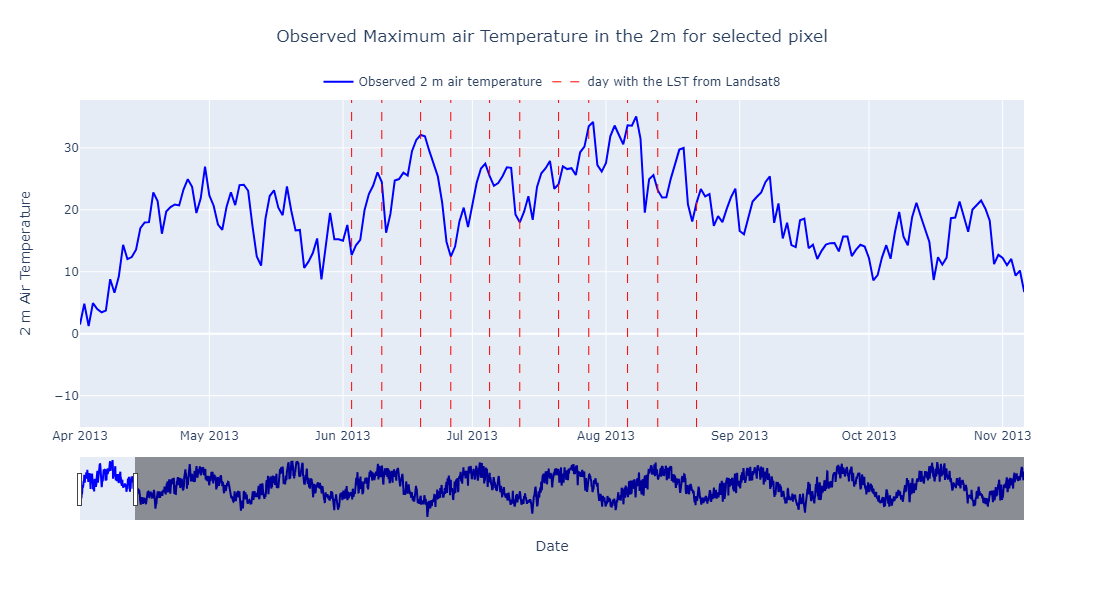

In [14]:
# Sample data
start_date = datetime(2013, 4, 1)
end_date = datetime(2023, 6, 30)
date_list = [start_date + timedelta(days=i) for i in range((end_date - start_date).days + 1)]
values = air_temp  # Replace this with your actual data
# Create figure
fig = go.Figure()
# Add line trace with legend
fig.add_trace(go.Scatter(x=date_list, y=values, mode='lines', name='Observed 2 m air temperature', line=dict(color='blue'), showlegend=True))
# Add title and axis labels
fig.update_layout(
     title={
        'text': "Observed Maximum air Temperature in the 2m for selected pixel",
        'x':0.5,
        'y':0.95,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title="Date",
    yaxis_title="2 m Air Temperature",
    width=1100,  # Width of the graph
    height=600,
    legend=dict(
        orientation="h",  # Set legend orientation to horizontal
        yanchor="top",  # Anchor legend to the top
        y=1.1,  # Adjust y position
        xanchor="center",  # Anchor legend to the center horizontally
        x=0.5  # Adjust x position
    )
)
# Add slider
fig.update_layout(
    xaxis=dict(
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)
# Add vertical lines for each date in date_list2
for date in date_list2:
    fig.add_shape(
        type="line",
        xref="x",
        yref="paper",
        x0=date,
        y0=0,
        x1=date,
        y1=1,
        line=dict(color="red", width=1, dash="dash"),
        name='Highlighted Date'
    )
# Add custom legend item for vertical lines
fig.add_trace(go.Scatter(
    x=[None],
    y=[None],
    mode='lines',
    line=dict(color='red', width=1, dash='dash'),
    name='day with the LST from Landsat8'
))
# Show plot
fig.show()

- When you take your Landsat8 LST data and look at the maximum observed 2m air temperature you will see if the LST temperature was reached during a heat-wave or just during a hotter day.
- Vertical red dash line represents the times for which we found Landsat8 LST pictures. **You can zoom in / out in the picture with a slider.** 

# 3. Exposure and vulnerability of the population 


- We can use the maps of the distribution of the population across the interested area and look if the most populated areas overlay with the most overheated parts. 

- For the Zilina pilot, we collected data from the Zilina municipality office about the buildings that are usually crowded with huge masses of people, e.g. hospitals, stadiums, main squares, big shopping centers, main roads, and bigger factories... **You can apply your data in this part**   

- If places like these are overheated, a huge number of people can be negatively influenced by the Heat. With that, the risk probability also rises, and thus, these areas are prioritized for Heat mitigation measures.  

### Critical infrastructure for Zilina city (overcrowded places) 

In [14]:
# This code loads the Critical infrastructure data, these data were created by the Zilina municipality office
ci=f'{data_dir}/ci_features_ZA.shp'
CI=gpd.read_file(ci)
CI_WGS=CI.to_crs(epsg=4326)

### Vulnerable population

 1. you need to select:
      - in the Data Series palette - High-Resolution Population Density Maps and Demographic Estimates
      - Locations, click on more and write a state which you want
      - The data will be automatically displayed in the middle, just the click on the data and download
 3. Download the maps for the most vulnerable groups of the population seniors 65+ years and children under 5 years 
 4. When you download all these maps to the Heat-workflow data folder you  can use this code for data handling:
     - in the first step we load all the maps of the critical population 
     - then we calculate the sum of the vulnerable population from each of the maps
     - we classified the maps into 5 groups (equal intervals)
     - plot it next to a map of overheated areas.
- [[Vulnerable population data source for Slovakia](https://data.humdata.org/dataset/worldpop-age-and-sex-structures-for-slovakia)]
- [[Vulnerable population data source for all States](https://data.humdata.org/dataset?dataseries_name=Data%20for%20Good%20at%20Meta%20-%20High%20Resolution%20Population%20Density%20Maps%20and%20Demographic%20Estimates&groups=alb&q=&sort=last_modified%20desc&ext_page_size=25)]

In [7]:
# This code loads all population data and creates a raster stack from them 
poplist = glob( f'{data_dir}/pop/*.tif')
#
with rasterio.open(poplist[0]) as src0:
    meta = src0.meta
#
meta.update(count = len(poplist))
#
with rasterio.open(f'{data_dir}/Population_raster_stack.tif', 'w', **meta) as dst:
    for id, layer in enumerate(poplist, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1))

In [22]:
pop=f'{data_dir}/Population_raster_stack.tif'
pop = xr.open_dataset(pop)
pop=pop.sum(dim='band', skipna=True,  keep_attrs=True)
pop=pop['band_data']
pop=pop.rio.clip_box(minx=18.67, miny=49.175, maxx=18.8, maxy=49.250)
# Calculate the number of bins (classes)
num_bins = 5
# Equal interval classification
min_value = np.nanmin(pop)  # Minimum population value
max_value = np.nanmax(pop)  # Maximum population value
bin_width = (max_value - min_value) / num_bins  # Width of each bin
pop_bins = [min_value + i * bin_width for i in range(num_bins + 1)]  # Define bin boundaries
pop_values=[0, 1, 2, 3, 4, 5]
pop_class = reclassify(pop, bins=pop_bins, new_values=pop_values)

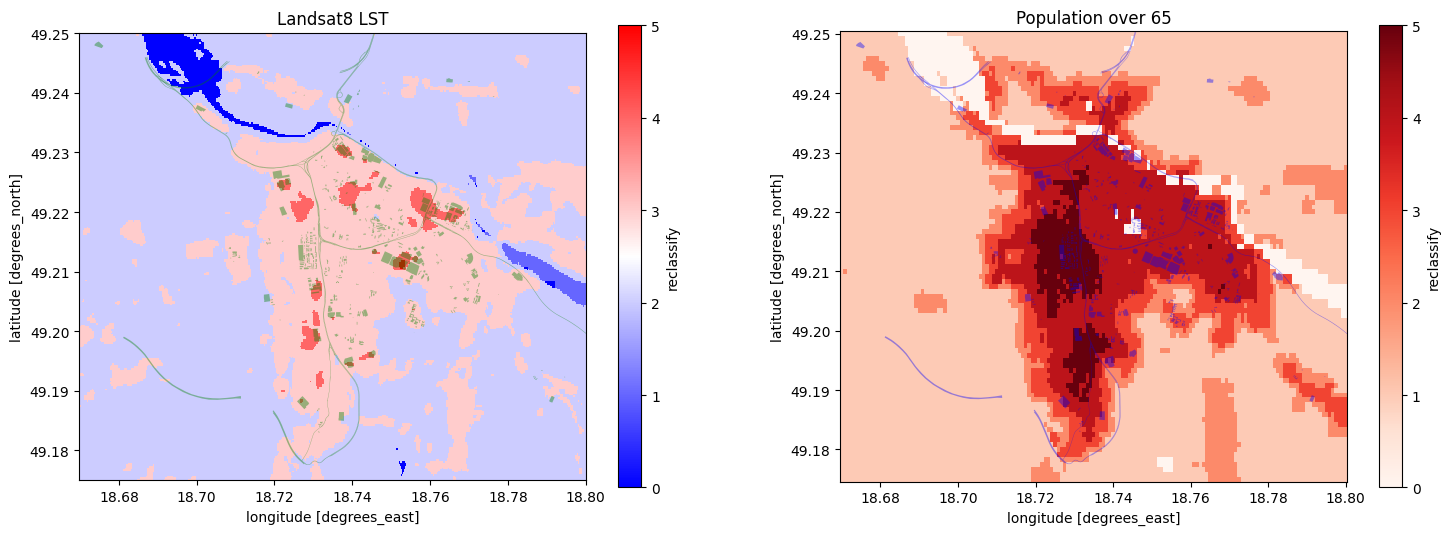

In [24]:
# plot of the Landsat8 LST and population concetration over specified age 
fig, axes=plt.subplots(ncols=2, figsize=(18,6))
lc_class.plot(ax=axes[0], cmap='bwr')
axes[0].set_title('Landsat8 LST')
CI_WGS.plot(ax=axes[0], color='green', alpha=0.4) 
pop_class.plot(ax=axes[1], cmap='Reds')
axes[1].set_title('Population over 65')
CI_WGS.plot(ax=axes[1], color='blue', alpha=0.4)
plt.draw()

Save data on the disk

In [25]:
# This code saves the data to results_dir
lc_class.rio.to_raster(raster_path=f'{results_dir}/risk_LST.tif')
pop_class.rio.to_raster(raster_path=f'{results_dir}/risk_pop.tif')

Load of the data 

In [10]:
# This code creates a raster stack from risk_LST and risk_pop data, we need this step for the next processing of the data 
S2list = glob( f'{results_dir}/risk_*.tif')
#
with rasterio.open(S2list[0]) as src0:
    meta = src0.meta
#
meta.update(count = len(S2list))
#
with rasterio.open(f'{results_dir}/risk_raster_stack.tif', 'w', **meta) as dst:
    for id, layer in enumerate(S2list, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1))

In [ ]:
# Plot a data
fig, ax = plt.subplots()
oa = lc_class.plot(ax = ax, cmap='Reds', add_colorbar=False)
cbar = fig.colorbar(oa, ticks=[0, 1, 2, 3, 4, 5])
cbar.ax.set_yticklabels(['No overheat', 'Very Low', 'Low', 'Medium', 'High', 'Very High'], size=10)
ax.set_xlabel('lon [deg_east]')
ax.set_ylabel('lat [deg_north]')
plt.title('Overheated areas in Zilina city', size=16, pad = 10)

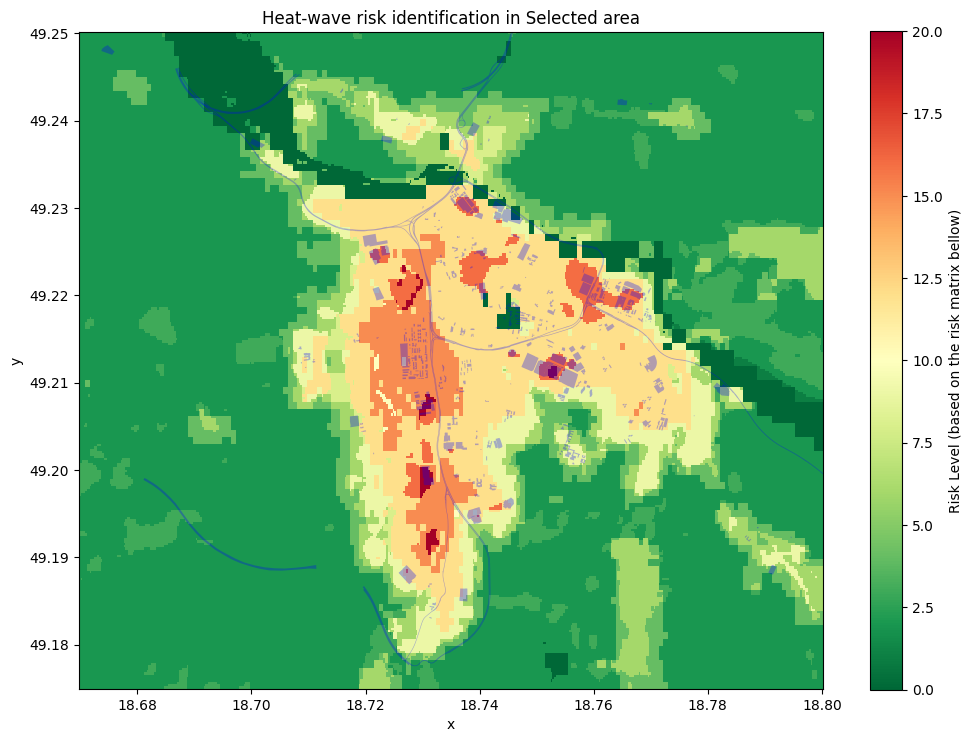

In [61]:
# This code calculates a risk map by multiplying a risk_LST and risk_pop data 
risk=f'{results_dir}/risk_raster_stack.tif'
risk = xr.open_dataset(risk)
risk=risk['band_data']
risk=(risk[0])*(risk[1])
# Plot the risk map
fig, ax = plt.subplots(figsize=(12, 9))
im = risk.plot(ax=ax, cmap='RdYlGn_r', add_colorbar=False)
CI_WGS.plot(ax=ax, color='blue', alpha=0.3)
# Set the title
ax.set_title('Heat-wave risk identification in Selected area')
# Add a colorbar
cbar = fig.colorbar(im, ax=ax, shrink=0.95)
cbar.set_label('Risk Level (based on the risk matrix bellow)')  # Set the label for the colorbar
plt.show()

Save on disk

In [ ]:
# This code saves the risk identification map in the results_dir
risk2.rio.to_raster(raster_path=f'{results_dir}/Heatwave_risk_identificationZA.tif')

- Based on the risk interpretation map (above), we can identify the places most influenced by the Heat-waves (dark red), for better visualization we can load a map with leafmap (below).
- In this notebook, we can also learn more about how to adapt to the heat-waves (part 6.), or how to interpret this risk map (risk matrix below)
- The map of the infrastructure (blue) can give us better information about which areas we should prioritize, in case of adaptation or which buildings or squares, etc. are most exposed to heat

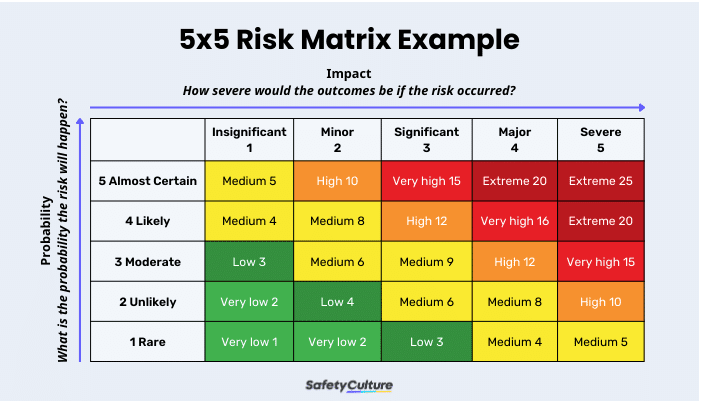

### Interactive mapping

- **To see these maps on the interactive zoom in/out map with the Open Street Base map run the code bellow**

In [15]:
# This code loads the Critical infrastructure map and covert it to EPSG:4326 crs, and saves it as Geojson
ci1 = gpd.read_file(f'{data_dir}/ci_features_ZA.shp', encoding='utf-8')
ci = ci1.to_crs(epsg=4326)
crs = ci.crs
#print("CRS of GeoJSON file:", crs)
ci.to_file(f'{data_dir}/ciZA4326.geojson', driver='GeoJSON')

In [16]:
# This code creates a tile client from risk maps
# First, create a tile server from local raster file
riskpop = TileClient(f'{results_dir}/risk_pop.tif')
riskLST = TileClient(f'{results_dir}/risk_LST.tif')
HWRI = TileClient(f'{results_dir}/Heatwave_risk_identificationZA.tif')

In [17]:
# This code creates ipyleaflet tile layer from that server
tpop = get_leaflet_tile_layer(riskpop, cmap='Reds',opacity=0.7, nodata=0, name='Risk population')
tLST = get_leaflet_tile_layer(riskLST, cmap='bwr',opacity=0.7, nodata=0, name='LST')
tHWRI = get_leaflet_tile_layer(HWRI, cmap='RdYlGn_r',opacity=0.7, nodata=0, name='Heat wave risk identification')

In [18]:
# This code loads the geojson Critical infrastructure map
with open(f'{data_dir}/ciZA4326.geojson', encoding='utf-8') as f1:
    geojson1 = json.load(f1)
geo_json1 = GeoJSON(data=geojson1, 
                    style={'opacity': 1, 'dashArray': '9', 'fillOpacity': 0.3, 'weight': 1},
                    name = 'Critical infrastructure for Zilina city')

In [19]:
# This code loads the geojson Critical infrastructure map
with open(f'{data_dir}/ciZA4326.geojson', encoding='utf-8') as f1:
    geojson1 = json.load(f1)
geo_json1 = GeoJSON(data=geojson1, 
                    style={'opacity': 1, 'fillOpacity': 0.3, 'weight': 1},
                    name = 'Critical infrastructure for Zilina city')

In [20]:
# This code plots all loades rasters and vectors on the ipyleaflet map
m = Map(center=riskLST.center(), zoom=riskLST.default_zoom)

control = LayersControl(position='topright')

m.add(tpop)
m.add(tLST)
m.add(tHWRI)

labels = ["Very low", "Low", "Medium", "Very high", "Extreme"]
colors = [(0, 104, 55), (35, 132, 67), (255, 255, 191), (255, 127, 0), (215, 25, 28)]

# Create legend HTML content with custom styles (smaller size)
legend_html = "<div style='position: absolute; bottom: 2px; left: 2px; padding: 10px; " \
              "background-color: #FFF; border-radius: 10px; box-shadow: 2px 2px 2px rgba(0,0,0,0.5); " \
              "width: 75px; height: 205px; '>"

# Append legend items (labels with colored markers)
for label, color in zip(labels, colors):
    color_hex = '#%02x%02x%02x' % color  # Convert RGB tuple to hex color
    legend_html += f"<p style='font-family: Arial, sans-serif; font-size: 14px; '>" \
                   f"<i style='background: {color_hex}; width: 10px; height: 10px; display: inline-block;'></i> {label}</p>"

legend_html += "</div>"


# Create a custom widget with the legend HTML
legend_widget = widgets.HTML(value=legend_html)

legend_control = WidgetControl(widget=legend_widget, position='bottomleft')
m.add_control(legend_control)

m.add(control)
m.add(geo_json1)

m

Map(center=[49.2125405, 18.734994], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

# Conclusion

- You can add or remove a map by "click" on the "layer control" in the top right corner, or "Zoom in/out" by "click" on the [+]/[-] in the top left corner 
- **We recommend first unclicking all the maps and then displaying them one by one, the transparency of the maps allows you to see which areas on the OpenStreetMap are most exposed to the heat, and in combination with the distribution of the vulnerable population, you can easily identify which areas should be prioritized for the application of the heat mitigation measures.** 